Implement Neural Network without using any framework or libraries

```
- Softmax, Cross-Entropy-Loss, 
- Forward propagation, Backward propagation, Backward propagation with regularization
- Gradient descent, Train/Test, Compute Accuracy and Run-through
```

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import argparse
import functools

In [ ]:
def softmax(x):
  """ 
  Compute the softmax function for a batch of input values 
  x: a 2-dimensional numpy float array of shape bath_size * number_of_classes
  first dimension is the batch size, and the second corresponds to every 
  class in the output
  
  Returns a 2-dimensional float array with the softmax results same shape as x 
  Avoid overflow, when large numbers are used for computation like e^10000
  """ 
  batch_size, _ = x.shape
  exp_x = np.exp(x + np.max(x))
  return exp_x / exp_x.sum(axis=1).reshape((batch_size, 1))

In [ ]:
def sigmoid(x):
  """ Compute the sigmoid function for the given input (numpy float array) """
  return 1 / (1 + np.exp(-x))

In [ ]:
def get_initial_params(input_size, num_hidden, num_output): 
  """ 
  A function to initialize model parameters 
  A dictionary mapping of parameter names to numpy arrays containing the inital
  values for those parameters. 
    - W1 the weight matrxi for the hidden layer of size input_size x num_hidden
    - b1 is the bias vector for the hidden layer of size num_hidden 
    - W2 the weight matrix for the output layers of size num_hidden x num_output 
    - b2 the vector for the output layer of size num_output 
    Weight matrices are initialized with random normal distribution centered 
    on 0 and with scale 1 
  """
  params = {
      'W1': np.random.standard_normal(size=(input_size, num_hidden)),
      'b1': np.zeros((num_hidden, 1)),
      'W2': np.random.standard_normal(size=(num_hidden, num_output)),
      'b2': np.zeros((num_output, 1)),
  }
  return params


In [ ]:
def avg_batch_cross_entropy_loss(y, y_hat): 
  """ Compute the average batch cross entropy loss """ 
  y_hat[ y_hat == 0 ] = 1 
  y_log_y_hat = np.multiply(y, np.log(y_hat))
  sum_y_log_y_hat = np.sum(y_log_y_hat, axis=1)
  return np.mean(sum_y_log_y_hat)

In [ ]:
def forward_prop(data, labels, params):
  """ 
  Implement the forward layer given the data, labels, and params
  Input
    data: A numpy array containing the input, same for labels 
    params: mapping parameter names to numpy arrays contains W1, b1, W2, b2 
    W1 and b1 represent the weight and bias for the hidden layer of network
    W2 and b2 represent the weights and bias for the output layer of network 
  Output
    A  3-element tuple 
    1. A numpy array of the activations (after the sigmoid) of hidden layer)
    2. A numpy array output (after the softmax of output layer)
    3. The average loss for these data elements 
  """ 
  z_hidden = data.dot(params['W1']) + params['b1'].T
  a_hidden = sigmoid(z_hidden)
  z_output = a_hidden.dot(params['W2']) + params['b2'].T
  a_output = softmax(z_output)
  loss = - np.multiply(labels, np.log(a_output + 1e-16)).sum()
  loss /= data.shape[0]
  return a_hidden, a_output, loss 

In [ ]:
def backward_prop(data, labels, params, forward_prop_func):
  """ 
  Implement the backward propagation gradient computation step for NN 
  forward_prop_func: a function that followes forward_prop API 
  Returns a dictionary of strings to numpy arrays where each key represents 
  the name of a weight, and the values represent the gradient of the loss 
    with respect to that weight. 
  It should have W1, W2, b1 and b2  
  """ 
  a_hidden, a_output, loss = forward_prop_func(data, labels, params)
  batch_size, input_size = data.shape 
  _, num_output = labels.shape 
  _, num_hidden = a_hidden.shape 
  gradients = {} 
  delta_2 = a_output - labels 
  gradients['W2'] = np.matmul(a_hidden.T, delta_2) / batch_size
  delta_1 = np.matmul(params['W2'], delta_2.T) * (a_hidden * (1-a_hidden)).T 
  gradients['W1'] = np.matmul(data.T, delta_1.T) / batch_size  
  gradients['b1'] = np.sum(delta_1, axis=1).reshape((num_hidden,1))/batch_size
  gradients['b2'] = np.sum(delta_2, axis=0).reshape((num_output,1))/batch_size 
  
  return gradients 

In [ ]:
def backward_prop_regularized(data, labels, params, forward_prop_func, reg):
  """ 
  Implement the backward propagation gradient computation step for NN 
  Same as above with the regularization step 
  reg: the regularization strength 
  """ 
  a_hidden, a_output, loss = forward_prop_func(data, labels, params)
  batch_size, input_size = data.shape 
  _, num_output = labels.shape 
  _, num_hidden = a_hidden.shape 
  gradients = {} 

  delta_2 = a_output - labels 
  gradients['W2'] = np.matmul(a_hidden.T, delta_2)/batch_size + 2*reg*params['W2'] 
  delta_1 = np.matmul(params['W2'], delta_2.T) * (a_hidden * (1-a_hidden)).T 
  gradients['W1'] = np.matmul(data.T, delta_1.T)/batch_size + 2*reg*params['W1']
  gradients['b1'] = np.sum(delta_1, axis=1).reshape((num_hidden,1))/batch_size
  gradients['b2'] = np.sum(delta_2, axis=0).reshape((num_output,1))/batch_size 
     
  return gradients

In [ ]:
def update_params(params, gradients, learning_rate):
  params['W1'] -= learning_rate * gradients['W1']
  params['W2'] -= learning_rate * gradients['W2']
  params['b1'] -= learning_rate * gradients['b1']
  params['b2'] -= learning_rate * gradients['b2']


In [ ]:
def gradient_descent_epoch(train_data, train_labels, learning_rate, 
           batch_size, params, forward_prop_func, backward_prop_func):
  """
  Perform one epoch of gradient descent on the given training data using lr 
  It updates the parameters in params dictionary
  """
  n, d = train_data.shape
  batch_count = n // batch_size
  for b in range(batch_count):
    batch_start, batch_end = b*batch_size, (b+1)*batch_size
    batch_data = train_data[batch_start:batch_end]
    batch_labels = train_labels[batch_start:batch_end]
    gradients = backward_prop_func(
        batch_data, batch_labels, params, forward_prop_func)
    update_params(params, gradients, learning_rate)  
  
  return 

In [ ]:
def neural_network_train(
  train_data, train_labels, dev_data, dev_labels, 
  get_initial_params_func, forward_prop_func, backward_prop_func,
  num_hidden=300, learning_rate=5, num_epochs=30, batch_size=1000):
  """
  Train model using gradient descent for specified number of epochs.
  Evaluates loss and accuracy on training and dev set 
  -- at the end of each epoch --.
  train_data and train_labels: numpy arrays 
  """
  (nexp, dim) = train_data.shape
  params = get_initial_params_func(dim, num_hidden, 10) 

  cost_train, cost_dev, accuracy_train, accuracy_dev = [], [], [], []

  for epoch in range(num_epochs):
    gradient_descent_epoch(train_data, train_labels, learning_rate, 
                    batch_size, params, forward_prop_func, backward_prop_func)
    
    hidden, output, cost = forward_prop_func(train_data, train_labels, params)
    cost_train.append(cost)
    epoch_train_accuracy = compute_accuracy(output, train_labels)
    accuracy_train.append(epoch_train_accuracy)

    hidden, output, cost = forward_prop_func(dev_data, dev_labels, params)
    cost_dev.append(cost)
    epoch_dev_accuracy = compute_accuracy(output, dev_labels)
    accuracy_dev.append(epoch_dev_accuracy)

    print('epoch {} of {}: training accuracy = {}; dev accuracy = {}'.format(
        epoch+1, num_epochs, epoch_train_accuracy, epoch_dev_accuracy))

  return params, cost_train, cost_dev, accuracy_train, accuracy_dev  

In [ ]:
def neural_network_test(data, labels, params):
  """ Predict labels and compute accuracy for held-out test data """
  hidden, output, cost = forward_prop(data, labels, params)
  accuracy = compute_accuracy(output, labels)
  return accuracy 

In [ ]:
def compute_accuracy(output, labels):
  accuracy = (np.argmax(output,axis=1) == np.argmax(labels,axis=1)).sum() \
              * 1. / labels.shape[0]
  return accuracy 

In [ ]:
def one_hot_labels(labels):
  """ Convert labels from integers to one hot encoding """
  one_hot_labels = np.zeros((labels.size, 10))
  one_hot_labels[np.arange(labels.size), labels.astype(int)] = 1
  return one_hot_labels 

In [ ]:
def run_train_test(name, all_data, all_labels, 
                   backward_prop_func, num_epochs, plot=True):
  """ Trains model, applies model to test data, and (optionally) plots loss """
  params, cost_train, cost_dev, accuracy_train, accuracy_dev = \
    neural_network_train(
        all_data['train'], all_labels['train'], 
        all_data['dev'], all_labels['dev'],
        get_initial_params, forward_prop, backward_prop_func,
        num_hidden=300, learning_rate=5, num_epochs=num_epochs, batch_size=1000
  )

  t = np.arange(num_epochs)
  
  if plot:
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(t, cost_train,'r', label='train')
    ax1.plot(t, cost_dev, 'b', label='dev')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    if name == 'baseline':
      ax1.set_title('Without Regularization')
    else:
      ax1.set_title('With Regularization')
    ax1.legend()

    ax2.plot(t, accuracy_train,'r', label='train')
    ax2.plot(t, accuracy_dev, 'b', label='dev')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    ax2.legend()

    fig.savefig('./' + name + '.pdf')
  
  accuracy = neural_network_test(all_data['test'], all_labels['test'], params)
  print('For model %s, got accuracy: %f' % (name, accuracy))
    
  return accuracy

In [ ]:
def read_from_file(images_file, labels_file):
  """ load images and labels """ 
  x = np.loadtxt(images_file, delimiter=',')
  y = np.loadtxt(labels_file, delimiter=',') 
  return x, y

In [ ]:
from google.colab import files
files.upload()

Saving images_test.csv.gz to images_test.csv.gz
Saving images_train.csv.gz to images_train.csv.gz
Saving labels_test.csv.gz to labels_test.csv.gz
Saving labels_train.csv.gz to labels_train.csv.gz


In [ ]:
!gzip -d images_test.csv.gz
!gzip -d images_train.csv.gz
!gzip -d labels_train.csv.gz
!gzip -d labels_test.csv.gz

In [ ]:
ls

images_test.csv   labels_test.csv   sample_data/
images_train.csv  labels_train.csv


In [ ]:
np.random.permutation(30000)

array([20656, 15296, 19089, ...,  7903,  9230, 13907])

In [ ]:
num_epochs = 30 
plot = True
np.random.seed(100)

train_data, train_labels = read_from_file('images_train.csv', 'labels_train.csv')
train_labels = one_hot_labels(train_labels)
perm = np.random.permutation(60000)
train_data = train_data[perm, :]
train_labels=train_labels[perm, :]

dev_data = train_data[0:10000, :]
dev_labels = train_labels[0:10000, :]
train_data = train_data[10000:, :]
train_labels = train_labels[10000:, :]

mean = np.mean(train_data)
std = np.std(train_data)
train_data = (train_data - mean) / std 
dev_data = (dev_data - mean) / std 

test_data, test_labels = read_from_file('images_test.csv', 'labels_test.csv')
test_labels = one_hot_labels(test_labels)
test_data = (test_data - mean) / std 

all_data = {'train': train_data, 
            'dev': dev_data, 
            'test': test_data }

all_labels = {'train': train_labels, 
              'dev': dev_labels, 
              'test': test_labels}

In [ ]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((50000, 784), (50000, 10), (10000, 784), (10000, 10))

epoch 1 of 30: training accuracy = 0.86688; dev accuracy = 0.8526
epoch 2 of 30: training accuracy = 0.90572; dev accuracy = 0.8804
epoch 3 of 30: training accuracy = 0.92472; dev accuracy = 0.8931
epoch 4 of 30: training accuracy = 0.93698; dev accuracy = 0.901
epoch 5 of 30: training accuracy = 0.94596; dev accuracy = 0.9055
epoch 6 of 30: training accuracy = 0.95196; dev accuracy = 0.91
epoch 7 of 30: training accuracy = 0.9575; dev accuracy = 0.9122
epoch 8 of 30: training accuracy = 0.96186; dev accuracy = 0.9161
epoch 9 of 30: training accuracy = 0.96538; dev accuracy = 0.9169
epoch 10 of 30: training accuracy = 0.96868; dev accuracy = 0.9185
epoch 11 of 30: training accuracy = 0.9715; dev accuracy = 0.9196
epoch 12 of 30: training accuracy = 0.974; dev accuracy = 0.919
epoch 13 of 30: training accuracy = 0.9759; dev accuracy = 0.9206
epoch 14 of 30: training accuracy = 0.97772; dev accuracy = 0.9216
epoch 15 of 30: training accuracy = 0.97902; dev accuracy = 0.9216
epoch 16 of 3

0.968

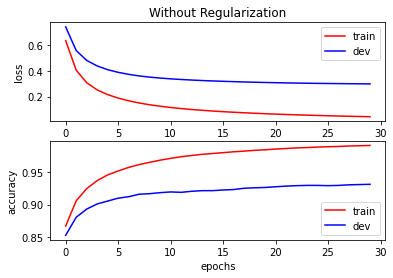

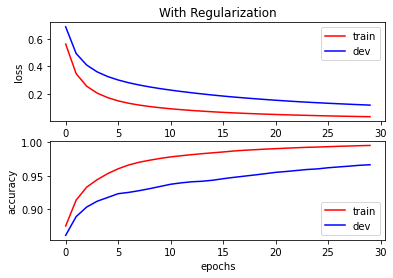

In [ ]:
baseline_acc = run_train_test('baseline', all_data, all_labels, 
                backward_prop, num_epochs, plot)

reg_acc = run_train_test('regularized', all_data, all_labels, 
            functools.partial(backward_prop_regularized, reg=0.0001),
            num_epochs, plot)

reg_acc 